In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Analysis

In [2]:
df = pd.read_csv('reviews_badminton/data.csv')

In [3]:
df.shape

(8518, 8)

In [4]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [5]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [6]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [7]:
df = df.fillna('Not Specified')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Reviewer Name    8518 non-null   object
 1   Review Title     8518 non-null   object
 2   Place of Review  8518 non-null   object
 3   Up Votes         8518 non-null   object
 4   Down Votes       8518 non-null   object
 5   Month            8518 non-null   object
 6   Review text      8518 non-null   object
 7   Ratings          8518 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 532.5+ KB


## Value Mapping

In [9]:
df['Ratings'].unique()

array([4, 1, 3, 5, 2], dtype=int64)

In [10]:
df=df[df['Ratings']!=3]

In [11]:
sentiment_mapping = {
    1: 'Negative',
    2: 'Negative',
    4: 'Positive',
    5: 'Positive'
}

df['Sentiment'] =df['Ratings'].map(sentiment_mapping)

In [12]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,Sentiment
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,Positive
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,Negative
4,ASHIK P A,Over priced,Not Specified,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,Negative
5,Baji Sankar,Mind-blowing purchase,"Certified Buyer, Hyderabad",173.0,45.0,Oct 2018,Good quality product. Delivered on time.READ MORE,5,Positive


In [13]:
df['Review text'] = df['Review text'].str.replace('READ MORE', '')

In [14]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,Sentiment
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,Positive
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,Negative
4,ASHIK P A,Over priced,Not Specified,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,Negative
5,Baji Sankar,Mind-blowing purchase,"Certified Buyer, Hyderabad",173.0,45.0,Oct 2018,Good quality product. Delivered on time.,5,Positive


## Splitting the data

In [15]:
X=df[['Review text']]
y=df['Sentiment']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [17]:
stemmer=PorterStemmer()

In [18]:
lemmatizer=WordNetLemmatizer()

## Data Cleaning

In [19]:
def preprocess(text, flag, n=2):
    # remove special characters
    sentence = re.sub(r'[^a-zA-Z]', ' ', text)
    # convert sentence into lower case
    sentence = sentence.lower()
    # tokenize sentence into words
    tokens = sentence.split()
    
    # Remove 'not' from default English stopwords
    custom_stopwords = set(stopwords.words("english")) - {'not'}
    
    # remove stop words
    clean_tokens = [token for token in tokens if token not in custom_stopwords]
    
    # stemming/lemmatization
    if flag == 'stem':
        clean_tokens = [stemmer.stem(token) for token in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
    
    # Generate n-grams
    ngrams_list = list(ngrams(clean_tokens, n))
    ngrams_text = [' '.join(gram) for gram in ngrams_list]
    
    return pd.Series(' '.join(ngrams_text))

### Text Cleaning on train data

In [20]:
X_train.head()

,Review text
1655,Good
4036,Good
1372,Very good.
3877,Nice
2091,Nice product and fast delivery


In [21]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [22]:
X_train_transformed= X_train['Review text'].progress_apply(lambda x: preprocess(x, flag='lemma'))

X_train_transformed.head()

100%|████████████████████████████████████████████████████████████████████████████| 5927/5927 [00:03<00:00, 1628.69it/s]


,0
1655,
4036,
1372,
3877,
2091,nice product product fast fast delivery


In [23]:
X_train_transformed.columns = ['Clean Review text']

X_train_transformed.head()

,Clean Review text
1655,
4036,
1372,
3877,
2091,nice product product fast fast delivery


In [24]:
X_train_transformed.to_csv(r'reviews_badminton\X_train_transformed.csv')

### Text Cleaning on test data

In [25]:
X_test.head()

,Review text
705,Nice product
4086,Good enough to play
6965,good for practice...
5830,Unbelievable at this price :)
4144,Once again fabulous work flipkart.Great produc...


In [26]:
X_test_transformed= X_test['Review text'].progress_apply(lambda x: preprocess(x, flag='lemma'))

X_test_transformed.head()

100%|████████████████████████████████████████████████████████████████████████████| 1976/1976 [00:00<00:00, 2765.60it/s]


,0
705,nice product
4086,good enough enough play
6965,good practice
5830,unbelievable price
4144,fabulous work work flipkart flipkart great gre...


In [27]:
X_test_transformed.columns = ['Clean Review text']

X_test_transformed.head()

,Clean Review text
705,nice product
4086,good enough enough play
6965,good practice
5830,unbelievable price
4144,fabulous work work flipkart flipkart great gre...


In [28]:
X_test_transformed.to_csv(r'reviews_badminton\X_test_transformed.csv')

## Text Embedding

### Bag of words

In [29]:
vocab = CountVectorizer()

X_train_bow = vocab.fit_transform(X_train_transformed['Clean Review text'])

print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words: 1995
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (5927, 1995)


In [30]:
X_test_bow = vocab.transform(X_test_transformed['Clean Review text'])

In [31]:
X_test_bow.shape

(1976, 1995)

### Tf - Idf

In [32]:
vectorizer = TfidfVectorizer()

X_train_dtm = vectorizer.fit_transform(X_train_transformed['Clean Review text'])

X_train_dtm.shape

(5927, 1995)

In [33]:
X_test_dtm = vectorizer.transform(X_test_transformed['Clean Review text'])

X_test_dtm.shape

(1976, 1995)

## Model Training

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [35]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, precision_score, recall_score, f1_score

## Training Model using Bag-of-Words

In [36]:
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow,y_train)

LogisticRegression()

In [37]:
knn_bow = KNeighborsClassifier()
knn_bow.fit(X_train_bow,y_train)

KNeighborsClassifier()

In [38]:
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow,y_train)

MultinomialNB()

In [39]:
dt_bow = DecisionTreeClassifier()
dt_bow.fit(X_train_bow,y_train)

DecisionTreeClassifier()

In [40]:
rf_bow = RandomForestClassifier()
rf_bow.fit(X_train_bow,y_train)

RandomForestClassifier()

## Assessing Model Performance using Bag-of-Words

Evaluation Metrics for LogisticRegression() model

Train accuracy:  0.9525898430909397

Test accuracy:  0.9291497975708503

Confusion Matrix - Train:
[[ 582  236]
 [  45 5064]]


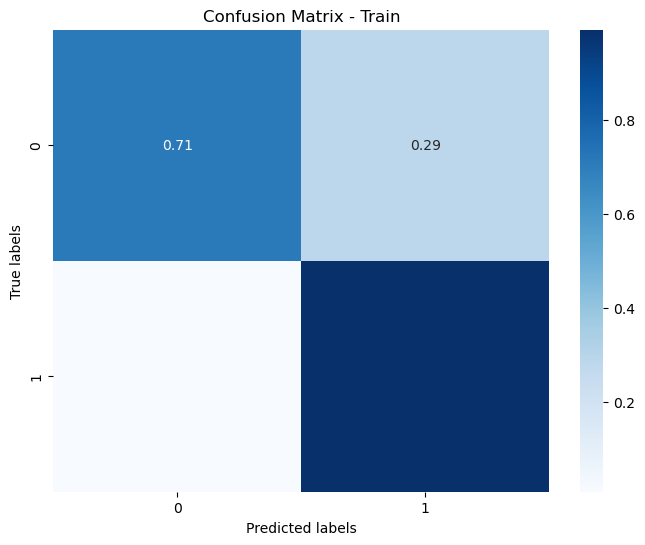

Confusion Matrix - Test:
[[ 161   98]
 [  42 1675]]


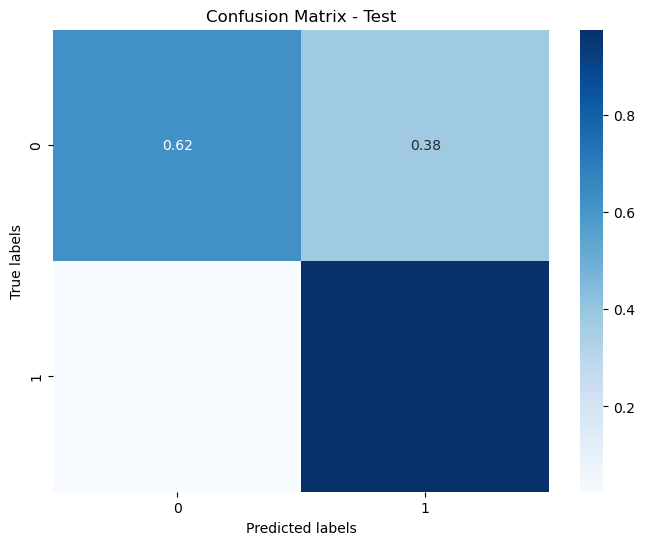

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.93      0.71      0.81       818
    Positive       0.96      0.99      0.97      5109

    accuracy                           0.95      5927
   macro avg       0.94      0.85      0.89      5927
weighted avg       0.95      0.95      0.95      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.79      0.62      0.70       259
    Positive       0.94      0.98      0.96      1717

    accuracy                           0.93      1976
   macro avg       0.87      0.80      0.83      1976
weighted avg       0.92      0.93      0.93      1976


Precision - Train: 0.951711957430249
Precision - Test: 0.9248527893584875

Recall - Train: 0.9525898430909397
Recall - Test: 0.9291497975708503

F1 Score - Train: 0.9498914839225276
F1 Score - Test: 0.9254242716013188

--------------------------------------------------
Evaluation Me

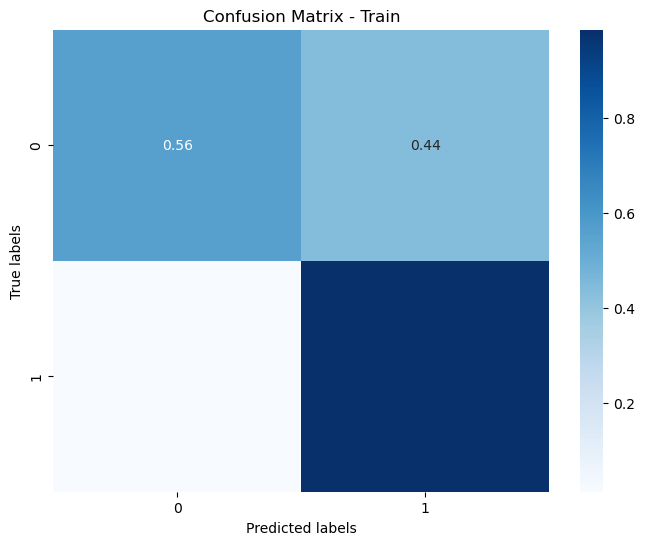

Confusion Matrix - Test:
[[ 130  129]
 [  34 1683]]


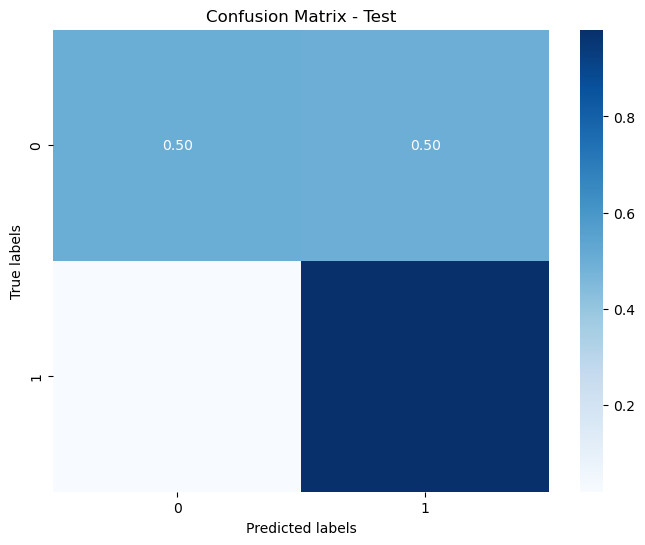

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.87      0.56      0.68       818
    Positive       0.93      0.99      0.96      5109

    accuracy                           0.93      5927
   macro avg       0.90      0.77      0.82      5927
weighted avg       0.92      0.93      0.92      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.79      0.50      0.61       259
    Positive       0.93      0.98      0.95      1717

    accuracy                           0.92      1976
   macro avg       0.86      0.74      0.78      1976
weighted avg       0.91      0.92      0.91      1976


Precision - Train: 0.924464219797543
Precision - Test: 0.9109656493329418

Recall - Train: 0.9276193689893707
Recall - Test: 0.9175101214574899

F1 Score - Train: 0.9207914751129167
F1 Score - Test: 0.9093573794483423

--------------------------------------------------
Evaluation Me

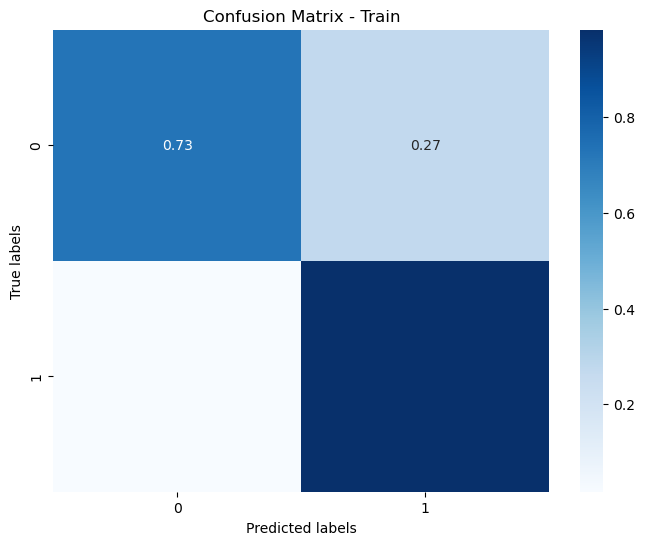

Confusion Matrix - Test:
[[ 156  103]
 [  52 1665]]


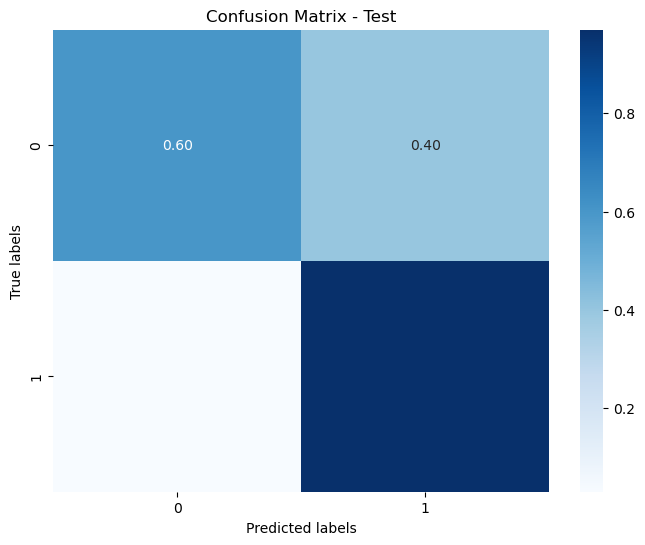

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.87      0.73      0.79       818
    Positive       0.96      0.98      0.97      5109

    accuracy                           0.95      5927
   macro avg       0.92      0.86      0.88      5927
weighted avg       0.95      0.95      0.95      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.75      0.60      0.67       259
    Positive       0.94      0.97      0.96      1717

    accuracy                           0.92      1976
   macro avg       0.85      0.79      0.81      1976
weighted avg       0.92      0.92      0.92      1976


Precision - Train: 0.9461117653640834
Precision - Test: 0.9166098956711305

Recall - Train: 0.9480344187615994
Recall - Test: 0.9215587044534413

F1 Score - Train: 0.9460527107430207
F1 Score - Test: 0.9178494680723971

--------------------------------------------------
Evaluation M

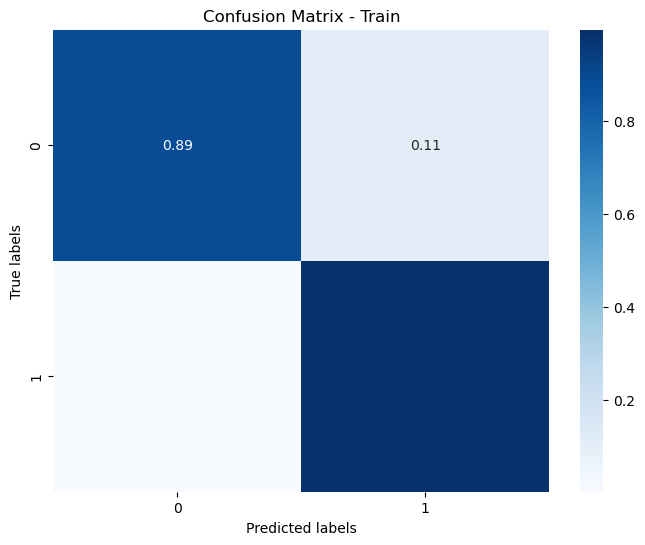

Confusion Matrix - Test:
[[ 184   75]
 [  72 1645]]


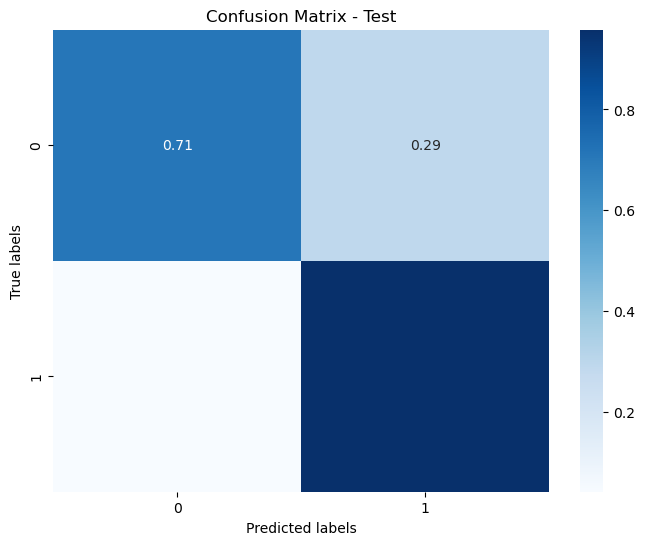

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.98      0.89      0.93       818
    Positive       0.98      1.00      0.99      5109

    accuracy                           0.98      5927
   macro avg       0.98      0.94      0.96      5927
weighted avg       0.98      0.98      0.98      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.72      0.71      0.71       259
    Positive       0.96      0.96      0.96      1717

    accuracy                           0.93      1976
   macro avg       0.84      0.83      0.84      1976
weighted avg       0.93      0.93      0.93      1976


Precision - Train: 0.9820815690057793
Precision - Test: 0.9252464898550044

Recall - Train: 0.9821157415218492
Recall - Test: 0.9256072874493927

F1 Score - Train: 0.9817461185453811
F1 Score - Test: 0.9254230766428871

--------------------------------------------------
Evaluation M

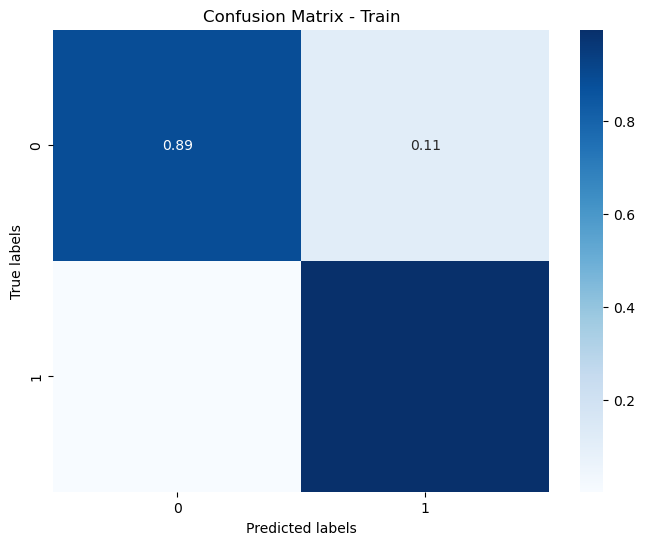

Confusion Matrix - Test:
[[ 191   68]
 [  49 1668]]


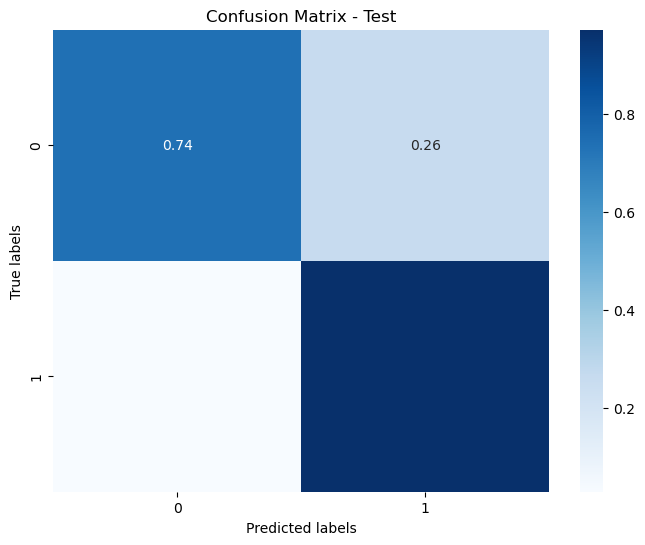

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.98      0.89      0.93       818
    Positive       0.98      1.00      0.99      5109

    accuracy                           0.98      5927
   macro avg       0.98      0.94      0.96      5927
weighted avg       0.98      0.98      0.98      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.80      0.74      0.77       259
    Positive       0.96      0.97      0.97      1717

    accuracy                           0.94      1976
   macro avg       0.88      0.85      0.87      1976
weighted avg       0.94      0.94      0.94      1976


Precision - Train: 0.9821001827182285
Precision - Test: 0.9392029721481122

Recall - Train: 0.9821157415218492
Recall - Test: 0.9407894736842105

F1 Score - Train: 0.9817358045139765
F1 Score - Test: 0.939825120999693

--------------------------------------------------


In [41]:
models = [lr_bow,knn_bow,nb_bow,dt_bow,rf_bow]
for model in models:
    print(f"Evaluation Metrics for {model} model")
    y_train_pred = model.predict(X_train_bow)
    y_test_pred = model.predict(X_test_bow)
    
    print()
    print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
    print()
    print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
    print()
    
    print('Confusion Matrix - Train:')
    train_cm = confusion_matrix(y_train, y_train_pred)
    print(train_cm)
    train_cm_norm = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm_norm, annot=True, fmt= '.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix - Train')
    plt.show()
    
    print('Confusion Matrix - Test:')
    test_cm = confusion_matrix(y_test, y_test_pred)
    print(test_cm)
    test_cm_norm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm_norm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix - Test')
    plt.show()
    
    print('Classification Report - Train:')
    print(classification_report(y_train, y_train_pred))
    print()
    
    print('Classification Report - Test:')
    print(classification_report(y_test, y_test_pred))
    print()
    
    print('Precision - Train:', precision_score(y_train, y_train_pred, average='weighted'))
    print('Precision - Test:', precision_score(y_test, y_test_pred, average='weighted'))
    print()
    
    print('Recall - Train:', recall_score(y_train, y_train_pred, average='weighted'))
    print('Recall - Test:', recall_score(y_test, y_test_pred, average='weighted'))
    print()
    
    print('F1 Score - Train:', f1_score(y_train, y_train_pred, average='weighted'))
    print('F1 Score - Test:', f1_score(y_test, y_test_pred, average='weighted'))
    print()
    
    print('-'*50)

## Training Model using TF-IDF 

In [42]:
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_dtm,y_train)

LogisticRegression()

In [43]:
knn_tfidf = KNeighborsClassifier()
knn_tfidf.fit(X_train_dtm,y_train)

KNeighborsClassifier()

In [44]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_dtm,y_train)

MultinomialNB()

In [45]:
dt_tfidf = DecisionTreeClassifier()
dt_tfidf.fit(X_train_dtm,y_train)

DecisionTreeClassifier()

In [46]:
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train_dtm,y_train)

RandomForestClassifier()

## Assessing Model Performance using TF-IDF

Evaluation Metrics for LogisticRegression() model

Train accuracy:  0.9326809515775266

Test accuracy:  0.930161943319838

Confusion Matrix - Train:
[[ 468  350]
 [  49 5060]]


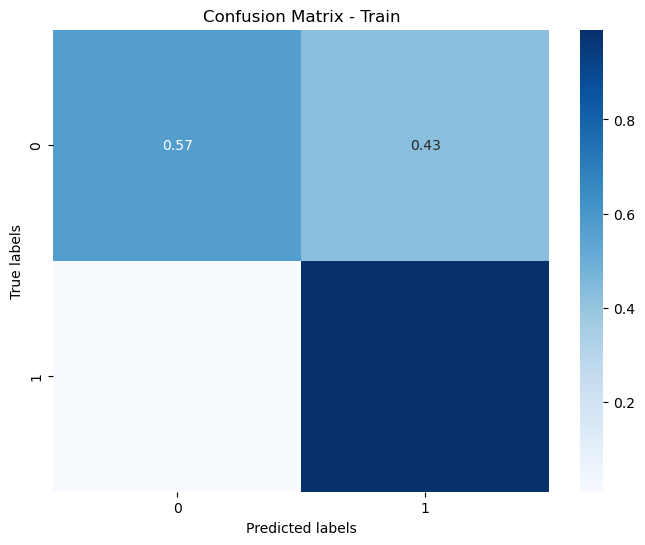

Confusion Matrix - Test:
[[ 147  112]
 [  26 1691]]


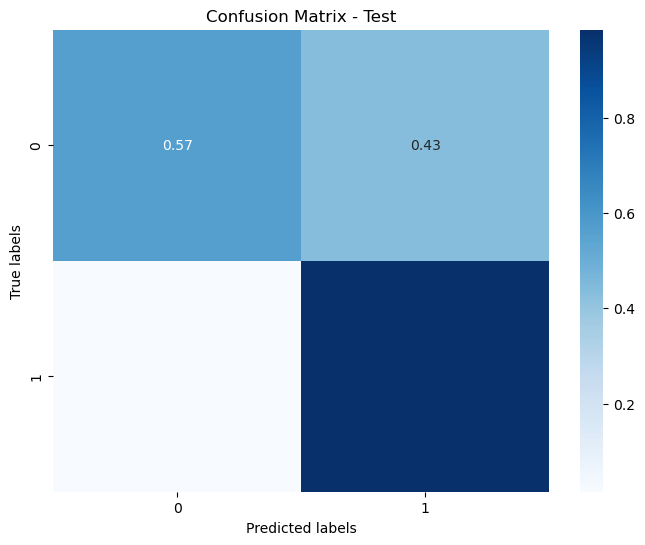

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.91      0.57      0.70       818
    Positive       0.94      0.99      0.96      5109

    accuracy                           0.93      5927
   macro avg       0.92      0.78      0.83      5927
weighted avg       0.93      0.93      0.93      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.85      0.57      0.68       259
    Positive       0.94      0.98      0.96      1717

    accuracy                           0.93      1976
   macro avg       0.89      0.78      0.82      1976
weighted avg       0.93      0.93      0.92      1976


Precision - Train: 0.9311532227704102
Precision - Test: 0.9263245708202067

Recall - Train: 0.9326809515775266
Recall - Test: 0.930161943319838

F1 Score - Train: 0.9260549639192278
F1 Score - Test: 0.9240636054369609

--------------------------------------------------
Evaluation Me

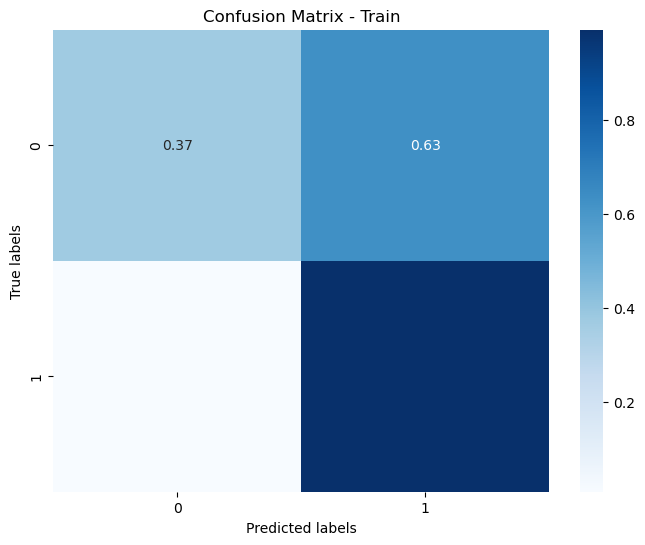

Confusion Matrix - Test:
[[  96  163]
 [  26 1691]]


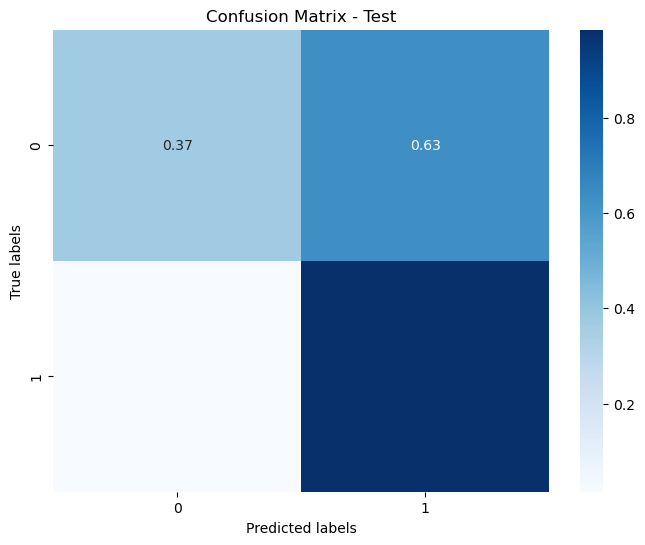

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.88      0.37      0.52       818
    Positive       0.91      0.99      0.95      5109

    accuracy                           0.91      5927
   macro avg       0.89      0.68      0.74      5927
weighted avg       0.90      0.91      0.89      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.79      0.37      0.50       259
    Positive       0.91      0.98      0.95      1717

    accuracy                           0.90      1976
   macro avg       0.85      0.68      0.73      1976
weighted avg       0.90      0.90      0.89      1976


Precision - Train: 0.9038595492033576
Precision - Test: 0.8956720884400631

Recall - Train: 0.9061920026995107
Recall - Test: 0.9043522267206477

F1 Score - Train: 0.8892434835276016
F1 Score - Test: 0.8889904555131459

--------------------------------------------------
Evaluation M

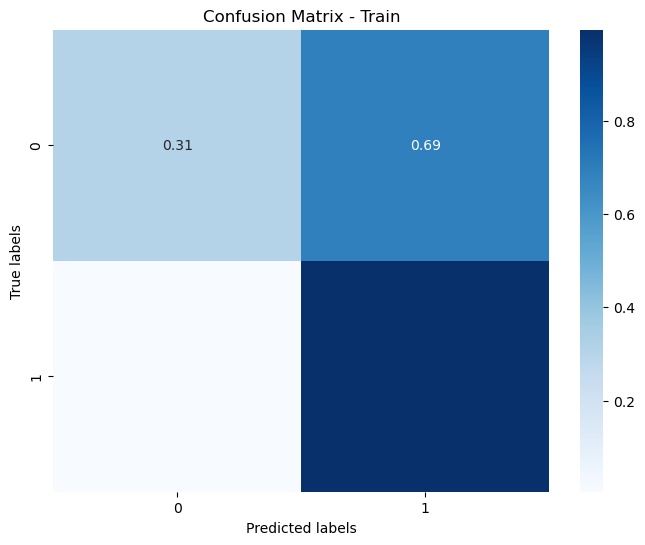

Confusion Matrix - Test:
[[  62  197]
 [   6 1711]]


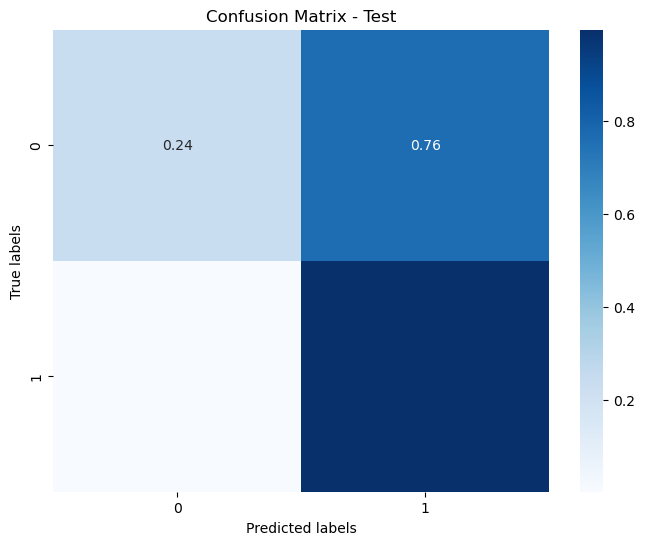

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.91      0.31      0.46       818
    Positive       0.90      1.00      0.95      5109

    accuracy                           0.90      5927
   macro avg       0.91      0.65      0.70      5927
weighted avg       0.90      0.90      0.88      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.91      0.24      0.38       259
    Positive       0.90      1.00      0.94      1717

    accuracy                           0.90      1976
   macro avg       0.90      0.62      0.66      1976
weighted avg       0.90      0.90      0.87      1976


Precision - Train: 0.9016628794031589
Precision - Test: 0.8987184760722206

Recall - Train: 0.900455542432934
Recall - Test: 0.8972672064777328

F1 Score - Train: 0.8783040203613335
F1 Score - Test: 0.8699706818209958

--------------------------------------------------
Evaluation Me

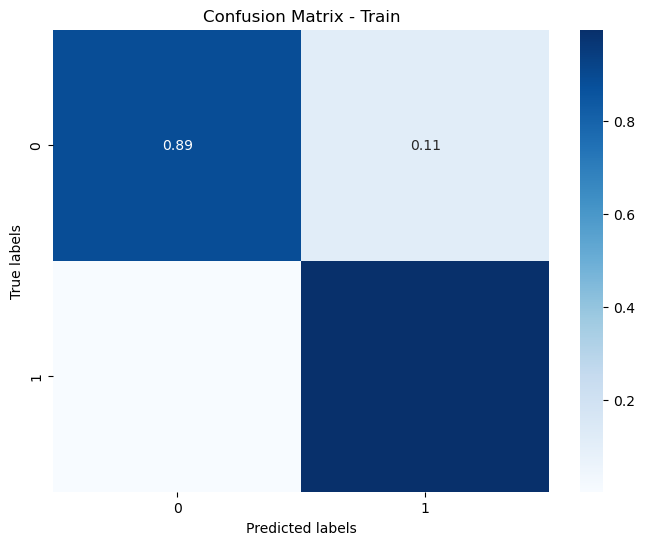

Confusion Matrix - Test:
[[ 175   84]
 [  66 1651]]


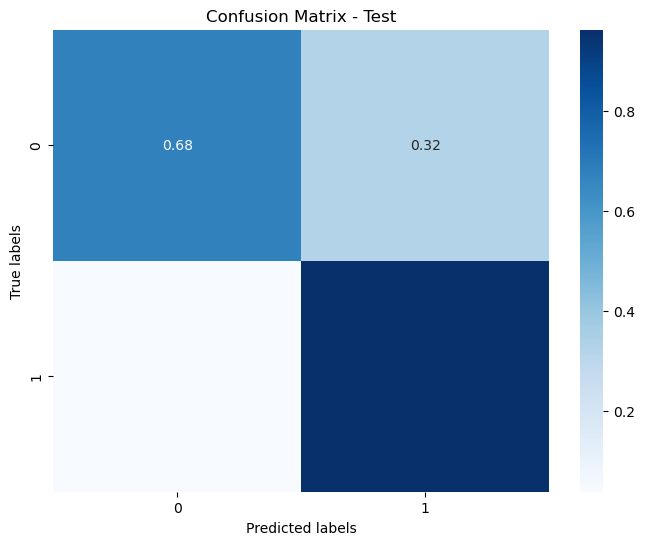

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.98      0.89      0.93       818
    Positive       0.98      1.00      0.99      5109

    accuracy                           0.98      5927
   macro avg       0.98      0.94      0.96      5927
weighted avg       0.98      0.98      0.98      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.73      0.68      0.70       259
    Positive       0.95      0.96      0.96      1717

    accuracy                           0.92      1976
   macro avg       0.84      0.82      0.83      1976
weighted avg       0.92      0.92      0.92      1976


Precision - Train: 0.9819145066461479
Precision - Test: 0.922035429736701

Recall - Train: 0.9819470221022439
Recall - Test: 0.9240890688259109

F1 Score - Train: 0.9815687104316005
F1 Score - Test: 0.9229205858482556

--------------------------------------------------
Evaluation Me

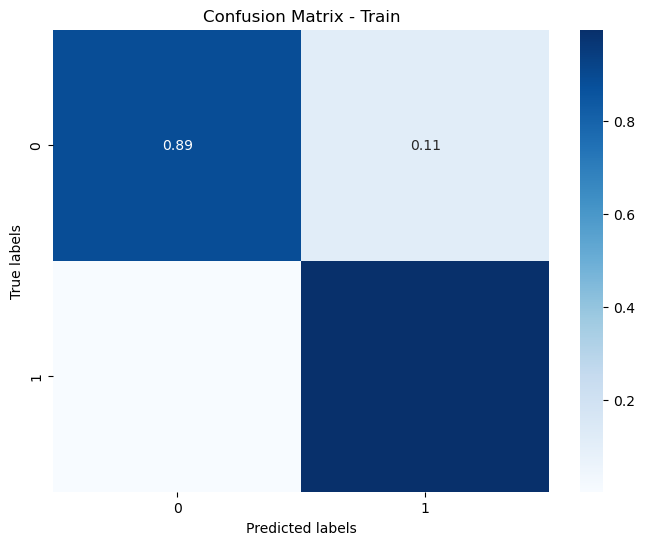

Confusion Matrix - Test:
[[ 185   74]
 [  38 1679]]


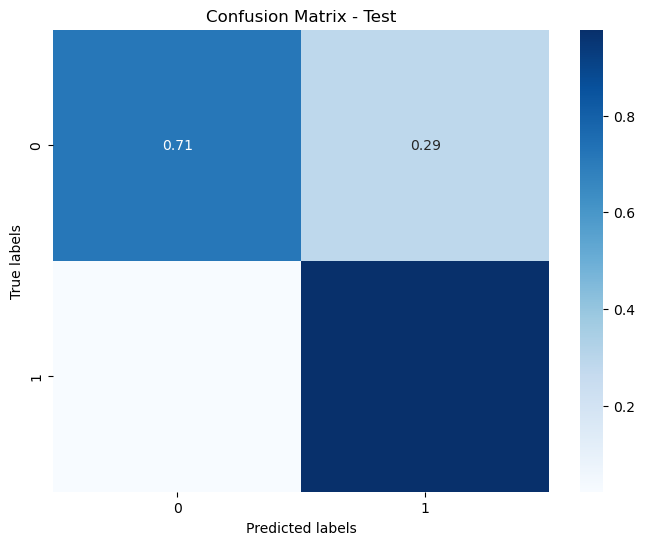

Classification Report - Train:
              precision    recall  f1-score   support

    Negative       0.98      0.89      0.93       818
    Positive       0.98      1.00      0.99      5109

    accuracy                           0.98      5927
   macro avg       0.98      0.94      0.96      5927
weighted avg       0.98      0.98      0.98      5927


Classification Report - Test:
              precision    recall  f1-score   support

    Negative       0.83      0.71      0.77       259
    Positive       0.96      0.98      0.97      1717

    accuracy                           0.94      1976
   macro avg       0.89      0.85      0.87      1976
weighted avg       0.94      0.94      0.94      1976


Precision - Train: 0.9819145066461479
Precision - Test: 0.9409843883601471

Recall - Train: 0.9819470221022439
Recall - Test: 0.9433198380566802

F1 Score - Train: 0.9815687104316005
F1 Score - Test: 0.9414971696421971

--------------------------------------------------


In [47]:
models = [lr_tfidf,knn_tfidf,nb_tfidf,dt_tfidf,rf_tfidf]
for model in models:
    print(f"Evaluation Metrics for {model} model")
    y_train_pred = model.predict(X_train_dtm)
    y_test_pred = model.predict(X_test_dtm)
    
    print()
    print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
    print()
    print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
    print()
    
    print('Confusion Matrix - Train:')
    train_cm = confusion_matrix(y_train, y_train_pred)
    print(train_cm)
    train_cm_norm = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm_norm, annot=True, fmt= '.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix - Train')
    plt.show()
    
    print('Confusion Matrix - Test:')
    test_cm = confusion_matrix(y_test, y_test_pred)
    print(test_cm)
    test_cm_norm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm_norm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix - Test')
    plt.show()
    
    print('Classification Report - Train:')
    print(classification_report(y_train, y_train_pred))
    print()
    
    print('Classification Report - Test:')
    print(classification_report(y_test, y_test_pred))
    print()
    
    print('Precision - Train:', precision_score(y_train, y_train_pred, average='weighted'))
    print('Precision - Test:', precision_score(y_test, y_test_pred, average='weighted'))
    print()
    
    print('Recall - Train:', recall_score(y_train, y_train_pred, average='weighted'))
    print('Recall - Test:', recall_score(y_test, y_test_pred, average='weighted'))
    print()
    
    print('F1 Score - Train:', f1_score(y_train, y_train_pred, average='weighted'))
    print('F1 Score - Test:', f1_score(y_test, y_test_pred, average='weighted'))
    print()
    
    print('-'*50)

In [62]:
from sklearn.pipeline import Pipeline

In [63]:
pipe = Pipeline(["vectorizer", vectorizer,
                "rf_tfidf",rf_tfidf])

In [64]:
pickle.dump(pipe, open('pipe.pkl','wb'))

In [51]:
import pickle

file_path = "rf_tfidf.pkl"

with open(file_path, "wb") as file:
    pickle.dump(rf_tfidf, file)


In [59]:
with open("rf_tfidf.pkl", "rb") as file:
    rf_tfidf_model = pickle.load(file)


dummy_test_data = ['its not bad']
dummy_test_data_tfidf = vectorizer.transform(dummy_test_data)
predictions = rf_tfidf.predict(dummy_test_data_tfidf)


print("Predictions:", predictions)

Predictions: ['Positive']


In [50]:
"""import os

# Specify the file name
file_path = "rf_tfidf.pkl"

# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"The file '{file_path}' has been deleted.")
else:
    print(f"The file '{file_path}' does not exist.")
"""

The file 'rf_tfidf.pkl' has been deleted.


In [61]:
pickle.dump(vectorizer, open('vector.pkl','wb'))

In [77]:
mod = pickle.load( open('rf_tfidf.pkl','rb'))

In [85]:
mod.fit(c,y_train)

RandomForestClassifier()

In [87]:
data = vec.transform(['good'])
mod.predict(data)

array(['Positive'], dtype=object)

In [75]:
vec = pickle.load( open('vector.pkl','rb'))

In [83]:
X_train

,Review text
1655,Good
4036,Good
1372,Very good.
3877,Nice
2091,Nice product and fast delivery
...,...
3879,good one but delivery was tooo late.
6147,Good
7158,this product was very good . quality is very g...
2761,It is worth the money we spend to buy it ........


In [84]:
c = vec.transform(X_train['Review text'])

In [73]:
model = pickle.load( open('pipe.pkl','rb'))

In [70]:
X_train

,Review text
1655,Good
4036,Good
1372,Very good.
3877,Nice
2091,Nice product and fast delivery
...,...
3879,good one but delivery was tooo late.
6147,Good
7158,this product was very good . quality is very g...
2761,It is worth the money we spend to buy it ........


In [88]:
xdata = pickle.dump(X_train, open('xdata.pkl','wb'))

In [89]:
ydata = pickle.dump(y_train, open('ydata.pkl','wb'))